# Generate Synthetic Images with DCGANs in Keras

## Import Libraries

In [16]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.1


##Load and Normalize the Data

In [17]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# normalize
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

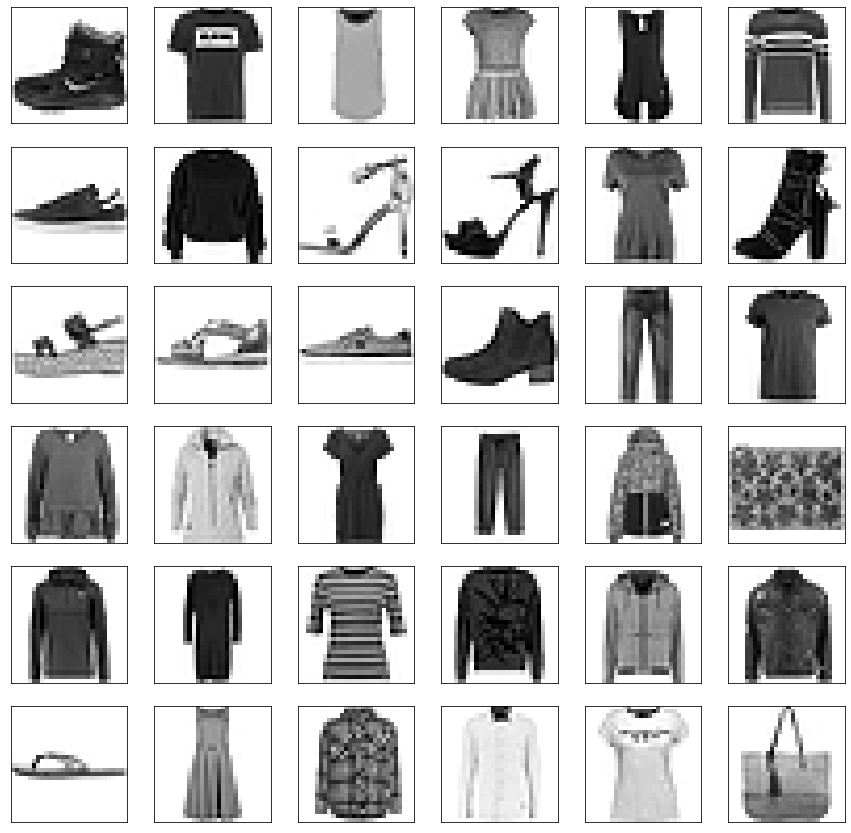

In [18]:
# Show some examples from dataset
plt.figure(figsize= (15,15))
for i in range(36):
  plt.subplot(6,6, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()  

##Creating Batches of Training Data

In [19]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1400)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(2)
# drop remainder, drops last remainder images from batch.

##Build the Generator Network for DCGAN

![GAN](https://miro.medium.com/max/1394/1*fd3QUV45REqZ_f7tjYs31g.png)

**Generator** is an upsampling network with fractionally-strided convolutions

**Discriminator** is a convolutional network which classifies images as fake or real

In [20]:
num_of_features = 128 # too features can end up having mostly black images.

generator = tf.keras.models.Sequential([
            tf.keras.layers.Dense(7 * 7 * 256, input_shape = [num_of_features]),
            tf.keras.layers.Reshape([7,7,256]),
            tf.keras.layers.BatchNormalization(momentum= 0.9),
            tf.keras.layers.Conv2DTranspose(256, (5,5), (2,2), padding = 'same',
                                            activation = 'selu'), #selu on purpose
            tf.keras.layers.BatchNormalization(momentum= 0.9),
            tf.keras.layers.Conv2DTranspose(1, (5,5), (2,2), padding = 'same',
                                            activation = 'tanh') # tanh on purpose            
                              
])

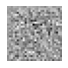

In [21]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

noise = tf.random.normal(shape = [1, num_of_features])
generated_image_with_noise = generator(noise, training = False)
show(generated_image_with_noise, 1)

##Build the Discriminator Network for DCGAN

In [22]:
discriminator = tf.keras.models.Sequential([
                tf.keras.layers.Conv2D(64, (5,5), padding= 'same', 
                                       input_shape = (28,28,1),
                                       activation = tf.keras.layers.LeakyReLU(0.24)),
                tf.keras.layers.Dropout(0.24),
                tf.keras.layers.Conv2D(128, (5,5), padding= 'same', 
                                       activation = tf.keras.layers.LeakyReLU(0.24)),
                tf.keras.layers.Dropout(0.24),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(1, activation='sigmoid') # real or fake?                                               
])

In [23]:
prediction = discriminator(generated_image_with_noise)
prediction
# not trained, yet.

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49764955]], dtype=float32)>

## Compile the Deep Convolutional Generative Adversarial Network (DCGAN)

In [24]:
loss = 'binary_crossentropy'
opt = tf.keras.optimizers.RMSprop(0.0007)
discriminator.compile(loss = loss, optimizer=opt)
discriminator.trainable = False

dcgan = tf.keras.models.Sequential([
        generator, discriminator                             
])
dcgan.compile(loss = loss, optimizer=opt)
dcgan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 28, 28, 1)         3265281   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 306945    
Total params: 3,572,226
Trainable params: 3,264,257
Non-trainable params: 307,969
_________________________________________________________________


## Define Training Procedure

In [25]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif",
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
      plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [26]:
seed = tf.random.normal(shape = (batch_size, 128))

In [27]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=7):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch {}/{}\ " .format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, num_features])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
                   # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

## Train DCGAN

In [28]:
x_train_dcgan = x_train.reshape(-1,28,28,1)

In [29]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1400)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(2)

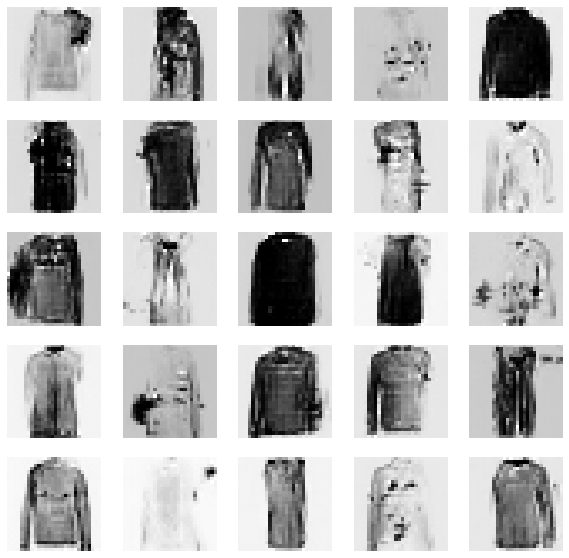

In [30]:
train_dcgan(dcgan, dataset, batch_size, num_of_features, epochs = 16)

##Generate Synthetic Images with DCGAN

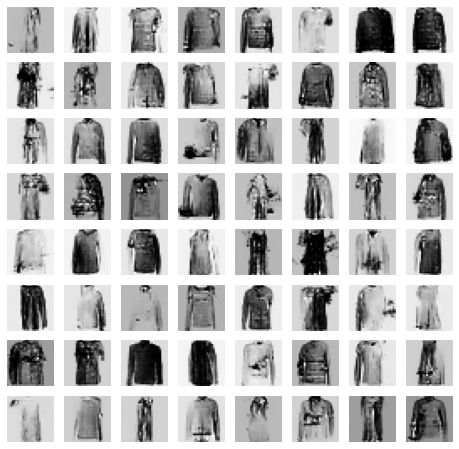

In [31]:
noise = tf.random.normal(shape = (batch_size, num_of_features))
generated_image_with_noise = generator(noise)
show(generated_image_with_noise, 8)
# there are some messy images.

In [ ]:
## Source: https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif

import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
display.Image(filename=anim_file)